# <center> Recommendation System </center>

<span style="font-size:30px float="left" "> <b>Recommendation  </b></span> perform as virtual salesmen dramatically
drive sales. They use input about a customer’s interests to generate a list of recommended items.
Many large Ecommerce websites apply Recommendation algorithms intensively and comprehensively. 

**Two typs of recommendation method** are Content-Based (CB)and Collaborative
Filtering (CF). Content-Based recommendation method and it focuses on the attributes of the
items and give you recommendations based on the similarity between them, without considering
the user’s behavior. The performance of CB strongly depends on the quality of the features.
Collaborative filtering (CF) is the workhorse of recommender engines which requires lot of
user-generated data and it doesn’t rely on the features of items. It can get quite complicated, but
it’s the state of art. Since our dataset doesn’t contain any feature of items, I mainly focus on the
Collaborative Filtering methods. The main idea underlying CF method is that similar or relevent
items is more likely to be purchased by users with similar preference. A intuitive way to say that
is:
1. “Customers who liked this item also liked … ”
2. “Customers who are similar to you also liked …"

**Two critical matrices** for the implementation are user-user matrix and user-item matrix, which are extremely sparse. After these two matrices were obtained, **Three algorithms** of  recommendation method are implemented from scratch here.
1. Clustering users using KMeans 
2. Item-Item similarity
3. User-Item collaborative filtering

In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import os
import math as mt
import heapq
import csv
from sparsesvd import sparsesvd
import scipy.sparse
from scipy.sparse.linalg import *
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy import stats 
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse as sp
import sklearn.preprocessing as pp
from itertools import chain
from collections import Counter
from scipy.sparse import csr_matrix
%matplotlib inline

# Preliminary Data Exploratory  

In [78]:
users = pd.read_csv('./tianchi_mobile_recommend_train_user.csv')
users.head()
print users.shape

(12256906, 6)


&nbsp;

**The behavior_type includes click, collect, add-to-cart and payment, and the corresponding behaviors are denoted by 1, 2, 3 and 4, respectively. The plot below shows the distribution of behavior_type count (in log)** 
    

[1, 2, 3, 4]


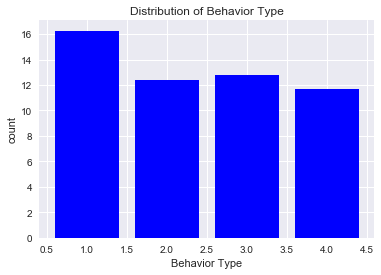

In [10]:
behaviorCount = Counter(users.behavior_type)
print behaviorCount.keys()
_ = plt.bar(behaviorCount.keys(), np.log(behaviorCount.values()),color="blue")
plt.title('Distribution of Behavior Type')
plt.xlabel('Behavior Type')
plt.ylabel('count')

**Payment information(who made the payment and which item paid for) is presumed to be more important than the other three behaviors, so it's distribution was analyzed further. In our dataset, some person made payments up to amost 700 times, and the numbers drops exponentially  **

In [24]:
payment = users.ix[users.behavior_type==4]
tt = payment[['user_id','item_id']].groupby('user_id').count().reset_index()
tt.columns = ['user_id', 'count_n_items']
ahhh = Counter(tt.count_n_items)

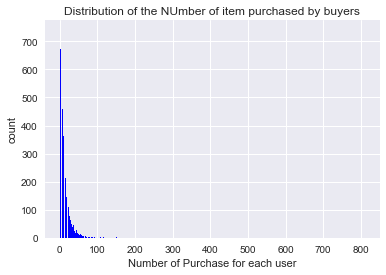

In [48]:
_ = plt.bar(ahhh.keys(), ahhh.values(),color="blue")
plt.title('Distribution of the NUmber of item purchased by buyers')
plt.xlabel('Number of Purchase for each user')
plt.ylabel('count')
# plt.xlim(0,200)

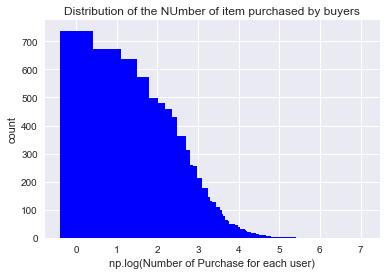

In [25]:
_ = plt.bar(np.log(ahhh.keys()), ahhh.values(),color="blue")
plt.title('Distribution of the NUmber of item purchased by buyers')
plt.xlabel('np.log(Number of Purchase for each user)')
plt.ylabel('count')

# Subset test and traing sets

In [53]:
origUserID_index_dict = dict([(orig_UserID,i)  for i, orig_UserID in enumerate(users.user_id.unique())]) 
origItemID_index_dict = dict([(orig_ItemID,i)  for i, orig_ItemID in enumerate(users.item_id.unique())])

index_origUserID_dict = dict([(i,orig_UserID)  for i, orig_UserID in enumerate(users.user_id.unique())]) 
index_origItemID_dict = dict([(i,orig_ItemID)  for i, orig_ItemID in enumerate(users.item_id.unique())])

np.random.seed(1)
testset_indx = np.random.choice(10000, 3000, replace=False)
testing_set = users[users['user_id'].isin([index_origUserID_dict[i] for i in testset_indx])]
training_set = users[-users['user_id'].isin([index_origUserID_dict[i] for i in testset_indx])]
#testing_set.to_csv('testing_dataset.csv', sep='\t')
#training_set.to_csv('training_dataset.csv', sep='\t')

In [72]:
payment_sub = users.ix[users.behavior_type==4].copy()
user_itemCount = payment_sub[['user_id',"item_id"]].groupby(['user_id']).count().reset_index()
useful_user = list(user_itemCount[user_itemCount.item_id>3].user_id)
Full_usefulUserActivity = users[users['user_id'].isin(useful_user)]
Full_usefulUserActivity.to_csv('Full_usefulUser.csv', sep='\t')

# Recommendation System Implementation

## * K-means  item-item clustering 

In [68]:
def item_to_item_matrix(users):
    """users is the df used to construct matrix:userId, itemId,value(behavior_type)"""
    
    #create 4 dict 
    global origUserID_index_dict
    origUserID_index_dict = dict([(orig_UserID,i)  for i, orig_UserID in enumerate(users.user_id.unique())]) 
        
    global origItemID_index_dict
    origItemID_index_dict = dict([(orig_ItemID,i)  for i, orig_ItemID in enumerate(users.item_id.unique())])

    global index_origUserID_dict
    index_origUserID_dict = dict([(i,orig_UserID)  for i, orig_UserID in enumerate(users.user_id.unique())]) 
    global index_origItemID_dict
    index_origItemID_dict = dict([(i,orig_ItemID)  for i, orig_ItemID in enumerate(users.item_id.unique())])
    
    purchased_grouped = users.copy()
    User_Row_Index = list(purchased_grouped["user_id"].map(origUserID_index_dict))
    Item_Col_Index = list(purchased_grouped["item_id"].map(origItemID_index_dict))

    crs_value = list(purchased_grouped.behavior_type)

    nrow = max(User_Row_Index)+1
    ncol = max(Item_Col_Index)+1
    
    #user to item 
    user_to_item_csr = csr_matrix((np.array(crs_value), (User_Row_Index , Item_Col_Index ) ), shape=(nrow, ncol),dtype=float)
    
    payment_sprs = user_to_item_csr.copy()
    
    csrNew=[]
    for i in np.nonzero(payment_sprs.sum(axis=1))[0]:
        sentence = np.repeat(payment_sprs[i,:].toarray().nonzero()[1].tolist(), payment_sprs[i,:].data.tolist())
        for L in xrange(1,len(sentence)):
            csrNew.append([(sentence[i], sentence[i+L]) for i,word in enumerate(sentence[:len(sentence)-L])])
        
    csr = Counter(list(chain.from_iterable(csrNew))) 

    
    itemCsr_row = []
    itemCsr_col = []
    for i in csr.keys():
        itemCsr_row.append(i[0])
        itemCsr_col.append(i[1])
    print max(itemCsr_col )
    print max(itemCsr_row)

    mtx1 = csr_matrix((np.array(csr.values()), (itemCsr_row, itemCsr_col) ), shape=(ncol,ncol),dtype=float)
    mtx2 = csr_matrix((np.array(csr.values()), (itemCsr_col, itemCsr_row) ), shape=(ncol, ncol),dtype=float)
    item_to_item_csr_mtx = mtx1 + mtx2
    return item_to_item_csr_mtx 

In [69]:
def RecommendItem(itemRowIndex,index_origItemID_dict,item_to_item_csr_mtx,K):
    """input: purchased iterm ID in row index"""
    """list of recommended iterm in original ID """
    #itemRowIndex = 772861
    val, count = np.unique(item_to_item_csr_mtx[itemRowIndex,:].data,return_counts=True)
    val = val[::-1]
    if len(val)==0:
        print 'item never purchased, not being able to match'
        
    else: 
        j = 0
        max10index = np.argwhere(list(chain.from_iterable(item_to_item_csr_mtx[itemRowIndex,:].toarray() ))  ==val[j] )
        max10index =list(chain.from_iterable(max10index) )
        #while (len(max10index) <10):
        while (len(max10index) <K) and (j+1<len(val)):    
            #print j 
            j = j+1
            a = np.argwhere(list(chain.from_iterable(item_to_item_csr_mtx[itemRowIndex,:].toarray() ))  ==val[j] )
            a = list(chain.from_iterable(a) )
            #print a
            max10index = max10index+a
            #print len(max10index)
        return [index_origItemID_dict[i] for i in max10index]


In [70]:
def returnAccuracy(K,table):  
    payment_test = table.copy()
    payment_test.head()
    tt = payment_test[['user_id','item_id']].groupby(['user_id','item_id']).count().reset_index().set_index(['user_id'])
    unique_user_test = list(np.unique(payment_test.user_id))
    print len(unique_user_test)
    acc=[]
    for j in xrange(len(unique_user_test)):   
        userID = unique_user_test[j]
        rec_list = []
        if len(tt.ix[userID]['item_id'].shape)>0:    
            for i in list(tt.loc[userID].item_id):
                #print i,origItemID_index_dict[i]
                itemRowIndex = origItemID_index_dict[i]
                rec = RecommendItem(itemRowIndex,index_origItemID_dict,item_to_item_csr_mtx,K)
                if (type(rec)==list):
                    rec_list.append(rec)
            #print j,set(list(chain.from_iterable(rec_list) ))& set(list(tt.loc[4913].item_id))
        else: 
            itemRowIndex = origItemID_index_dict[tt.ix[userID]['item_id']]
            #print j, set(list(chain.from_iterable(rec_list) ))& set(list(tt.loc[4913].item_id))
        if len(set(list(chain.from_iterable(rec_list) ))& set(list(tt.loc[4913].item_id)))>0:
            acc.append(j)
    return len(acc)/float(len(unique_user_test)
    

In [73]:
users =  pd.read_csv('Full_usefulUser.csv',sep = '\t')
users = users.ix[users.behavior_type==4].copy()
table = users[['user_id','item_id','behavior_type']].groupby(['user_id','item_id']).aggregate(np.sum).reset_index().copy()

In [ ]:
#takes long to run 
item_to_item_csr_mtx = item_to_item_matrix(table )
for K in [10,30,60]:o
    #table.ix[:100,:]
    print K,returnAccuracy(K,table)

In [ ]:
#k60
len(acc)/float(len(unique_user_test))

## * Item-Item similarity

There is one assumption underlying user-to-user collaborative filtering, which is users with
similar histories have similar preferences. So one user will be recommended the items purchased
by the most similar users. Thus a user-to-user similarity matrix should be constructed from
user-item matrix to find the most similar user.
The user-item matrix is constructed such that each combination of unique user and unique item
(element of matrix) will be given a value indicating the user’s preference of that item. Thus the
purchase history of each user is vectorized, ready to compute the similarities of users. ​One
specialty of this project is that there are multiple purchasing histories of the same pair of user and
item, unlike the rating scenario. So I group the records to only have unique combinations of
user and item. In order to increase the effect of the correlations, I accumulate all purchasing
histories by summing the column of behavior_type.

In [80]:
# find the items purchased by a user in a dataset
def item_record(user_id, dataset):
    items_record = dataset.item_id[dataset['user_id'] == user_id]
    return items_record.tolist()

len(item_record(6118, users))

117

In [82]:
# calculating the sparsity of matrix
print 1-float(4686904)/(len(users.user_id.unique())*len(users.item_id.unique()))

0.999837087579


### contruct item-item sparse matrix

In [83]:
purchased_grouped =users.groupby(['user_id','item_id']).aggregate(np.sum)
purchased_grouped = purchased_grouped.reset_index()
purchased_grouped.head()
user = purchased_grouped 

In [86]:
origUserID_index_dict = dict([(orig_UserID,i)  for i, orig_UserID in enumerate(purchased_grouped.user_id.unique())]) 
origItemID_index_dict = dict([(orig_ItemID,i)  for i, orig_ItemID in enumerate(purchased_grouped.item_id.unique())])

index_origUserID_dict = dict([(i,orig_UserID)  for i, orig_UserID in enumerate(purchased_grouped.user_id.unique())]) 
index_origItemID_dict = dict([(i,orig_ItemID)  for i, orig_ItemID in enumerate(purchased_grouped.item_id.unique())])

In [87]:
User_Row_Index = list(purchased_grouped["user_id"].map(origUserID_index_dict))
Item_Col_Index = list(purchased_grouped["item_id"].map(origItemID_index_dict))

In [88]:
# crs_value = list(purchased_grouped.behavior_type)
nrow = max(User_Row_Index)+1
ncol = max(Item_Col_Index)+1

user_item_sprs = csr_matrix((np.array(crs_value), (User_Row_Index , Item_Col_Index ) ), shape=(nrow, ncol),dtype=float)

When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
There are different metrics for similarities, like cosine similarity and jaccard similarity which are shown below. Here I chose a simpler metrice, especially for sparse matrix, based on the inner product.

In [ ]:
# user_item_sparse = sp.csc_matrix(user_item)
user_item = user_item.apply(pd.to_numeric).astype(float)
user_item_sparse = sp.csc_matrix(user_item)
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat
print cosine_similarities(user_item_sparse)

In [ ]:
def jaccard_similarities(mat):
    cols_sum = mat.getnnz(axis=0)
    ab = mat.T * mat

    # for rows
    aa = np.repeat(cols_sum, ab.getnnz(axis=0))
    # for columns
    bb = cols_sum[ab.indices]

    similarities = ab.copy()
    similarities.data /= (aa + bb - ab.data)

    return similarities
print jaccard_similarities(user_item_sparse)

### Similarity based on inner product (correlation matrix)

In [ ]:
user_similarity = user_item_sprs*user_item_sprs.transpose()

In [93]:
# find the most similar user
def most_similar_user(UserID):
    UserID_test = int(UserID)
    user_sim_list = user_similarity[origUserID_index_dict[UserID_test]].toarray()[0].tolist()
    similar_index = user_sim_list.index(heapq.nlargest(2, user_sim_list)[1])
#return the UserID of the most similar to given user
    similar_UserID = index_origUserID_dict[similar_index]
    return similar_UserID

In [ ]:
# find the favorite item of a given user


def favorite_item(UserID, rank):
    UsrID = int(UserID)
    temp = user.loc[user['user_id'] == UserID] 
    #index corresponding to the favorite item in temp subset
    favorite_item_index = temp['behavior_type'].tolist().index(heapq.nlargest(rank, temp['behavior_type'])[-1])
    favorite_item_id = temp.iloc[favorite_item_index]['item_id']
    return favorite_item_id

In [ ]:
def favorite_k_item(UserID, k):
    list_recom = []
    for i in range(k):
        list_recom.append( favorite_item(UserID, rank = i+1) )
    return list_recom
        

### Testing

To evaluate the efficiency of the algorithm, for each item the user purchased, we recommend k
other items that are most likely to be purchased in bundle (based on the algorithm). If the
intersection between what the user actually bought and our recommendation list is not empty, we have a successfully made a recommendation.

In [ ]:
# using top-k recommendated items as criterion
def test(UserID, k, testing_set):
    list_recom = favorite_k_item(UserID, k)
    testing_set.item_id[testing_set.behavior_type == 4]

In [ ]:
result = 0

testing_unique = testing_set.user_id.unique()
N = len(testing_unique)

    
for i in testing_unique:
    purchased = testing_set.item_id[np.logical_and(testing_set.behavior_type == 4, testing_set.user_id == i)]
    recommended = favorite_k_item(most_similar_user(i), 1)
    if len(np.intersect1d(purchased, recommended) ) >0:
        result = result + 1

In [ ]:
float(result)/N